In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from fracdiff.sklearn import Fracdiff,FracdiffStat
from scipy.stats import skew
from scipy.stats import kurtosis


from scipy.stats import jarque_bera
import statsmodels.api as sm

from hurst import compute_Hc

In [2]:
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


In [3]:
df = prepare_data('./VIXdata.txt')

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df = df.drop_duplicates()
df = df[df['vix']>0]
df['log_vix_diff'] = df['log_vix'].diff()
df.dropna(inplace=True)
df.head()

,Date_vix,Date,vix,log_vix,log_vix_diff
2,20010103 26.60,2001-01-03,26.60,3.280911,-0.119953
4,20010104 26.97,2001-01-04,26.97,3.294725,0.013814
6,20010105 28.67,2001-01-05,28.67,3.355851,0.061126
8,20010108 29.84,2001-01-08,29.84,3.395850,0.039998
10,20010109 27.99,2001-01-09,27.99,3.331847,-0.064002


In [5]:
d={'Date':df['Date'], 'VIX':df['vix'], 'Log VIX':df['log_vix'], 'Log diff':df['log_vix_diff']}

df_1 = pd.DataFrame(data=d)
df_1 = df_1.drop(df_1.index[:2262])
df_1=df_1.reset_index(drop=True)

In [6]:
df_1.head()

,Date,VIX,Log VIX,Log diff
0,2010-01-04,20.04,2.997730,-0.078660
1,2010-01-05,19.35,2.962692,-0.035038
2,2010-01-06,19.16,2.952825,-0.009868
3,2010-01-07,19.06,2.947592,-0.005233
4,2010-01-08,18.13,2.897568,-0.050024


In [7]:
# 取出需要预测的部分数据
start_index = 50
end_index = 500
subset = df_1.loc[start_index:end_index, 'Log diff']

In [8]:


# 创建 ARIMA 模型
model = ARIMA(subset, order=(1, 1, 1))

# 拟合模型
results = model.fit()

# 预测未来值
forecast = results.forecast()

# 输出预测结果
print('预测值为：', forecast)

预测值为： 501   -0.004856
dtype: float64


/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
forecast

501   -0.004856
dtype: float64

In [122]:
df_1.loc[df_1.index[501], :]

Date        2011-12-28 00:00:00
VIX                       23.52
Log VIX                3.157851
Log diff               0.070908
Name: 501, dtype: object

In [123]:
print(results.summary().as_text())

                               SARIMAX Results                                
Dep. Variable:               Log diff   No. Observations:                  451
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 495.840
Date:                Sat, 13 May 2023   AIC                           -985.680
Time:                        19:11:11   BIC                           -973.352
Sample:                             0   HQIC                          -980.821
                                - 451                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0971      0.036     -2.724      0.006      -0.167      -0.027
ma.L1         -1.0000      4.154     -0.241      0.810      -9.143       7.143
sigma2         0.0064      0.026      0.242      0.8

In [124]:
index = df_1[df_1['Date'] == '2019-11-1'].index
index

Int64Index([2475], dtype='int64')

In [235]:
df_1.loc[2475-100:2575, :] ##找日期

,Date,VIX,Log VIX,Log diff
2375,2019-06-12,15.91,2.766948,-0.005016
2376,2019-06-13,15.82,2.761275,-0.005673
2377,2019-06-14,15.28,2.726545,-0.034730
2378,2019-06-17,15.35,2.731115,0.004571
2379,2019-06-18,15.15,2.718001,-0.013115
...,...,...,...,...
2571,2020-03-23,61.59,4.120500,-0.069761
2572,2020-03-24,61.67,4.121798,0.001298
2573,2020-03-25,63.95,4.158102,0.036304
2574,2020-03-26,61.00,4.110874,-0.047228


# 1. ARIMA forecast with window size :100

In [126]:
fARI=[]

for i in range(0, 100):
   # 取出需要预测的部分数据
    start_index = 2475+i
    end_index = 2575+i
    
    subset = df_1.loc[start_index:end_index, 'VIX']
    model = ARIMA(subset, order=(1, 1, 1))
    results = model.fit()
    forecast = results.forecast()
    fARI.append(forecast)



In [127]:
Re = df_1.loc[2576:2675,'VIX']

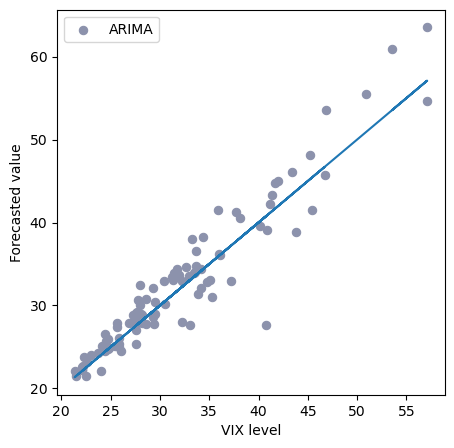

In [128]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(2576,2676)
y1=fARI #ARIMA预测的VIX值
ax.scatter(Re,y1,color='#8C92AC', linewidth=0.8, label='ARIMA')

#x2=np.arange(2576,2676)
#y2=Re
#ax.scatter(x2,y2,color='#d2b48c', linewidth=0.8, label='VIX')


ax.plot(Re,Re)

# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'





# 显示图形
fig.set_size_inches(5, 5)

plt.legend()

plt.xlabel('VIX level')
plt.ylabel('Forecasted value')
#plt.savefig('FIG/H.png', dpi=800)
plt.show()

# 2. ARIMA forecast with window size :150

In [229]:
f150=[]

for i in range(0, 100):
   # 取出需要预测的部分数据
    start_index = 2475+i-50
    end_index = 2575+i
    
    subset = df_1.loc[start_index:end_index, 'VIX']
    model = ARIMA(subset, order=(1, 1, 1))
    results = model.fit()
    forecast = results.forecast()
    f150.append(forecast)

In [63]:
Re = df_1.loc[2576:2675,'VIX']

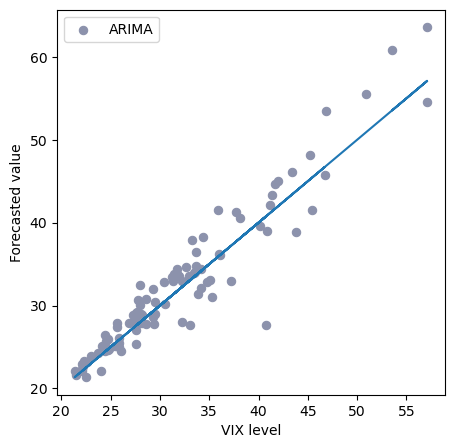

In [64]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(2576,2676)
y1=f150 #ARIMA预测的VIX值
ax.scatter(Re,y1,color='#8C92AC', linewidth=0.8, label='ARIMA')

#x2=np.arange(2576,2676)
#y2=Re
#ax.scatter(x2,y2,color='#d2b48c', linewidth=0.8, label='VIX')


ax.plot(Re,Re)

# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'





# 显示图形
fig.set_size_inches(5, 5)

plt.legend()

plt.xlabel('VIX level')
plt.ylabel('Forecasted value')
#plt.savefig('FIG/H.png', dpi=800)
plt.show()

# 3. ARIMA forecast with window size :200

In [236]:
f200=[]

for i in range(0, 100):
   # 取出需要预测的部分数据
    start_index = 2475+i-100
    end_index = 2575+i
    
    subset = df_1.loc[start_index:end_index, 'VIX']
    model = ARIMA(subset, order=(1, 1, 1))
    results = model.fit()
    forecast = results.forecast()
    f200.append(forecast)

In [17]:
Re = df_1.loc[2475:2575,'VIX']

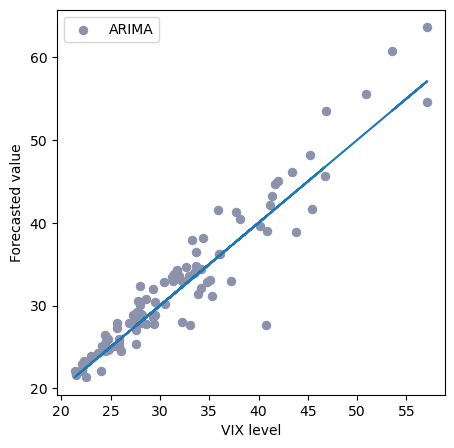

In [69]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(2576,2676)
y1=f200 #ARIMA预测的VIX值
ax.scatter(Re,y1,color='#8C92AC', linewidth=0.8, label='ARIMA')
#ax.scatter(Re,fARI,color='#5f9ea0', linewidth=0.8, label='ARIMA')
#ax.scatter(Re,f150,color='#d2b48c', linewidth=0.8, label='ARIMA')

#x2=np.arange(2576,2676)
#y2=Re
#ax.scatter(x2,y2,color='#d2b48c', linewidth=0.8, label='VIX')


ax.plot(Re,Re)

# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'





# 显示图形
fig.set_size_inches(5, 5)

plt.legend()

plt.xlabel('VIX level')
plt.ylabel('Forecasted value')
#plt.savefig('FIG/H.png', dpi=800)
plt.show()

# 4. ARRV forecast

In [1]:
def obtain_v(data,H):
    n = data.shape[0]
    S = np.zeros([n+2,n+2])

    for i in range(1,n+2):
        for j in range(1,n+2):
            S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/(2*(n+1)**(2*H))
    S = S[1:,1:]
    A = S[0:n,0:n]
    A_ = np.linalg.inv(A)
    B_T = S[-1,0:n]
  
    v = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]-data['u'].values[-1]
    u_hat = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]
    return v,u_hat

In [2]:
## 定义那个R1n^2/R2n
def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)

In [ ]:
## 找lambda
def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

In [ ]:
## 计算fractional Gaussian noise Z_t
def compute_z(v,lambda_):
    return np.sign(v)*np.power(abs(v),lambda_)

In [ ]:
def obtain_true_ar(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

## 高写的傻逼代码

In [22]:
def obtain_params(data):
    log_vix = data['log_vix'].values
    z_i = data['z_i'].values
    res = minimize(
    objective_function,
    x0=0.5 * np.random.random(3),
    args=(log_vix,z_i),
)
    return res

In [74]:

def obtain_train(df_ori):
    #

    # value_first = df_ori['residual'].values[0]
    # df_ori['residual'] = df_ori['residual'] - value_first
    # df_ori['residual_mean'] =  df_ori['residual'].mean()
    # df_ori['lr'] = 2 * np.linspace(0, 1, df_ori.shape[0]) * df_ori['residual'].mean()
    df_ori['x'] = df_ori['residual'] # - df_ori['lr']
    # df_ori['x'] = df_ori['residual']
    df_ori['y'] = df_ori['x'].diff()
    # print("value_first in obtain_train is ", value_first)
    
    return df_ori,0 # value_first


def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

def obtain_residual_by_ar(df_):
    acf_params_ = acf(df_['log_vix'],nlags=50)
    model_ = AutoReg(df_['log_vix'], lags=1).fit()
    #predict = model_.predict()
    #print("predict is ", predict)
    df_['ar_predict'] = predict.values

    df_['residual'] = df_['log_vix']-df_['ar_predict']

    forecast  =model_.forecast(1)
    return model_.params,df_, forecast


def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2)) # 可以加入对过去的多个依赖
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint
from scipy.special import gamma

In [177]:
def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

def obtain_residual_by_ar(df_):
    acf_params_ = acf(df_['log_vix'],nlags=50)
    model_ = AutoReg(df_['log_vix'], lags=1).fit()
    predict = model_.predict()
    #print("predict is ", predict)
    df_['ar_predict'] = predict.values

    df_['residual'] = df_['log_vix']-df_['ar_predict']

    forecast  =model_.forecast(1)
    return model_.params,df_, forecast


def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2)) # 可以加入对过去的多个依赖
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint

In [178]:
def compute_z(v,lambda_):
    return np.sign(v)*np.power(abs(v),lambda_)

In [179]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    params_ar,df_ori, forecast = obtain_residual_by_ar(df_ori)
 
    forecast = forecast.values
 
    df_ori = df_ori.dropna()
    df_ori,value_first = obtain_train(df_ori)
    df_ = df_ori.dropna()
   

    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    print("lambda_ =", lambda_)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_) #+1/lambda_
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    print("series is ", series)
    # Evaluate Hurst equation
    H=0.231183
    v,u_hat = obtain_v(df_,H)
    print("v = ", v)
    u_tmp = np.sign(df_['u'].values[-1])* np.power(np.abs(df_['u'].values[-1]),lambda_)

    z = compute_z(v,lambda_)
    # res = obtain_params(df_)
    # x = res.x
    #print("z = ",z)
    v_i = df_['log_vix'].values[-1] #volatility past value
    ar_i = df_['ar_predict'].values[-1] #ar approximte last value
    result = forecast +0.5*(z)+0*(v_i-(ar_i)) # predict_self(df_,v,x,lambda_)   ########


    df_true = df[df['Date'] >= date][0:n+1].reset_index(drop=True)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
   # print("value_first is in main:",value_first)from statsmodels.tsa.ar_model import AutoReg
    # print("2*df_['residual_mean'].values[-1] is in main:",2*df_['residual_mean'].values[-1])
    # log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    # return [forecast, result+2*df_['residual_mean'].values[-1]+value_first, date_,true_value,H,lambda_],df_,value_first
    return [forecast[0], result[0], date_,true_value,H,lambda_,value_first,z[0],u_tmp,u_hat[0]],df_,value_first

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

df = prepare_data('./data/VIXdata.txt')
n = 100
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2019-08-22']['Date'].values[0:100] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)
result

In [181]:
df_result = pd.DataFrame(result,columns=['ar','zhu','date','true','H','lambda_','value_first','z','u_tmp','u_hat'])
df_result

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat
0,4.128940,4.131270,2020-03-27,4.182661,0.231183,1.550746,0,0.004661,0.001472,0.046290
1,4.203896,4.191554,2020-03-30,4.044454,0.231183,1.531453,0,-0.024685,0.191231,0.250341
2,4.057372,4.070436,2020-03-31,3.980429,0.231183,1.511474,0,0.026128,0.046571,0.221158
3,3.990280,3.988281,2020-04-01,4.044103,0.231183,1.505325,0,-0.003998,0.075408,0.154060
4,4.055752,4.036026,2020-04-02,3.930059,0.231183,1.494375,0,-0.039452,0.442971,0.464959
...,...,...,...,...,...,...,...,...,...,...
95,3.189956,3.173401,2020-08-12,3.103689,0.231183,1.182608,0,-0.033109,0.235182,0.238042
96,3.116591,3.130796,2020-08-13,3.096934,0.231183,1.173103,0,0.028408,-0.004902,0.037302
97,3.111001,3.107602,2020-08-14,3.093313,0.231183,1.166451,0,-0.006798,0.007927,0.001951
98,3.109623,3.107306,2020-08-17,3.061052,0.231183,1.189699,0,-0.004634,0.104838,0.139292


In [182]:
reg_model = LinearRegression()

reg_model.fit(df_result[['z']].values,df_result['true']-df_result['ar'])

LinearRegression()

In [183]:
df_result.columns

Index(['ar', 'zhu', 'date', 'true', 'H', 'lambda_', 'value_first', 'z',
       'u_tmp', 'u_hat'],
      dtype='object')

In [184]:
from sklearn.linear_model import LinearRegression

In [185]:
reg_model.coef_

array([0.50284398])

In [186]:
# Loss function definition
def hmse(y_true,y_pred):
    ratio = y_pred/y_true
    return np.mean(np.power((ratio[abs(ratio)<200]-1),2))

def hmae(y_true,y_pred):
    ratio = y_pred/y_true
    return np.mean(abs(ratio[abs(ratio)<200]-1))

def mse(y_true,y_pred):
    return np.mean(np.power(np.abs(y_true-y_pred),2))

def mae(y_true,y_pred):
    return np.mean(np.abs(y_true-y_pred))

In [212]:
# HMSE, HMAE    Mine
hmARRV = [hmse(df_result['true'].values,df_result['zhu'].values),hmae(df_result['true'].values,df_result['zhu'].values)]

mARRV = [mse(df_result['true'].values,df_result['zhu'].values),mae(df_result['true'].values,df_result['zhu'].values)]
# HMSE, HMAE      ARIMA
hmARIMA = hmse(df_result['true'].values,np.log(fARI)),hmae(df_result['true'].values,np.log(fARI))
mARIMA = mse(df_result['true'].values,np.log(fARI)),mae(df_result['true'].values,np.log(fARI))

print("ARRV的hmse和hmae:",hmARRV)
print("ARRV的mse和mae:",mARRV)
print("ARIMA的hmse和hmae:",hmARIMA)
print("ARIMA的mse和mae:",mARIMA)




ARRV的hmse和hmae: [0.0004461729109661501, 0.016441974524792374]
ARRV的mse和mae: [0.005629997465780043, 0.05734543046071755]
ARIMA的hmse和hmae: (0.00946466078447988, 0.07665629176403457)
ARIMA的mse和mae: (0.11455635198738985, 0.2654943117977982)


In [190]:
y2=np.exp(df_result['zhu'])

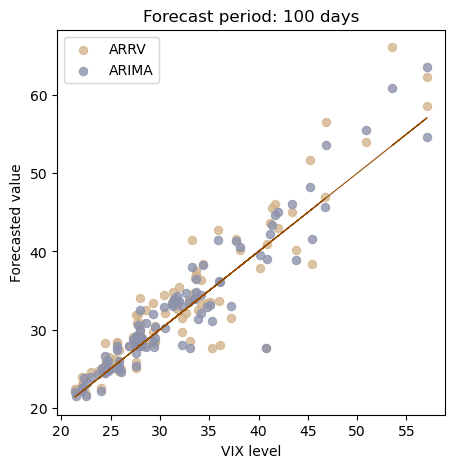

In [213]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(2576,2676)
y1=fARI #ARIMA预测的VIX值
ax.scatter(Re,y2,color='#d2b48c', linewidth=0.8, label='ARRV',alpha=0.8)
ax.scatter(Re,y1,color='#8C92AC', linewidth=0.8, label='ARIMA',alpha=0.8)

#x2=np.arange(2576,2676)
#y2=Re
#ax.scatter(x2,y2,color='#d2b48c', linewidth=0.8, label='VIX')


ax.plot(Re,Re,color='#964B00',linewidth=0.8)

# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'





# 显示图形
fig.set_size_inches(5, 5)

plt.legend()
ax.set_title('Forecast period: 100 days' )
plt.xlabel('VIX level')
plt.ylabel('Forecasted value')
plt.savefig('FIG/win100.png', dpi=800)
plt.show()

# 2. Window size 150 days

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

df = prepare_data('./data/VIXdata.txt')
n = 150
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2019-08-22']['Date'].values[0:100] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)


In [225]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    params_ar,df_ori, forecast = obtain_residual_by_ar(df_ori)
 
    forecast = forecast.values
 
    df_ori = df_ori.dropna()
    df_ori,value_first = obtain_train(df_ori)
    df_ = df_ori.dropna()
   

    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    #print("lambda_ =", lambda_)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_) #+1/lambda_
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    #print("series is ", series)
    # Evaluate Hurst equation
    H=0.231183
    v,u_hat = obtain_v(df_,H)
    print("v = ", v)
    u_tmp = np.sign(df_['u'].values[-1])* np.power(np.abs(df_['u'].values[-1]),lambda_)

    z = compute_z(v,lambda_)
    # res = obtain_params(df_)
    # x = res.x
    #print("z = ",z)
    v_i = df_['log_vix'].values[-1] #volatility past value
    ar_i = df_['ar_predict'].values[-1] #ar approximte last value
    result = forecast +0.56*(z)+0*(v_i-(ar_i)) # predict_self(df_,v,x,lambda_)   ########


    df_true = df[df['Date'] >= date][0:n+1].reset_index(drop=True)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
   # print("value_first is in main:",value_first)from statsmodels.tsa.ar_model import AutoReg
    # print("2*df_['residual_mean'].values[-1] is in main:",2*df_['residual_mean'].values[-1])
    # log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    # return [forecast, result+2*df_['residual_mean'].values[-1]+value_first, date_,true_value,H,lambda_],df_,value_first
    return [forecast[0], result[0], date_,true_value,H,lambda_,value_first,z[0],u_tmp,u_hat[0]],df_,value_first

In [226]:
df_result = pd.DataFrame(result,columns=['ar','zhu','date','true','H','lambda_','value_first','z','u_tmp','u_hat'])
df_result

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat
0,4.122031,4.125065,2020-03-27,4.182661,0.231183,1.472795,0,0.006069,-0.113721,-0.197282
1,4.196349,4.183562,2020-03-30,4.044454,0.231183,1.477332,0,-0.025574,0.210137,0.264252
2,4.050721,4.065067,2020-03-31,3.980429,0.231183,1.467911,0,0.028692,-0.078182,-0.087178
3,3.983597,3.981649,2020-04-01,4.044103,0.231183,1.470710,0,-0.003896,0.094189,0.177620
4,4.049940,4.030017,2020-04-02,3.930059,0.231183,1.458317,0,-0.039846,0.397891,0.421846
...,...,...,...,...,...,...,...,...,...,...
95,3.189623,3.173239,2020-08-12,3.103689,0.231183,1.382054,0,-0.032769,0.871970,0.821322
96,3.117236,3.125618,2020-08-13,3.096934,0.231183,1.374190,0,0.016763,0.371731,0.537728
97,3.111017,3.106215,2020-08-14,3.093313,0.231183,1.367347,0,-0.009604,0.579410,0.637448
98,3.108177,3.104572,2020-08-17,3.061052,0.231183,1.371267,0,-0.007210,0.525333,0.597946


In [222]:
reg_model = LinearRegression()

reg_model.fit(df_result[['z']].values,df_result['true']-df_result['ar'])

LinearRegression()

In [223]:
df_result.columns

Index(['ar', 'zhu', 'date', 'true', 'H', 'lambda_', 'value_first', 'z',
       'u_tmp', 'u_hat'],
      dtype='object')

In [224]:
reg_model.coef_

array([0.56535626])

In [230]:
# HMSE, HMAE    Mine
hmARRV = [hmse(df_result['true'].values,df_result['zhu'].values),hmae(df_result['true'].values,df_result['zhu'].values)]

mARRV = [mse(df_result['true'].values,df_result['zhu'].values),mae(df_result['true'].values,df_result['zhu'].values)]
# HMSE, HMAE      ARIMA
hmARIMA = hmse(df_result['true'].values,np.log(f150)),hmae(df_result['true'].values,np.log(f150))
mARIMA = mse(df_result['true'].values,np.log(f150)),mae(df_result['true'].values,np.log(f150))

print("ARRV的hmse和hmae:",hmARRV)
print("ARRV的mse和mae:",mARRV)
print("ARIMA的hmse和hmae:",hmARIMA)
print("ARIMA的mse和mae:",mARIMA)

ARRV的hmse和hmae: [0.00043098768677500234, 0.01578229610720646]
ARRV的mse和mae: [0.0054852896206868075, 0.05518803794753554]
ARIMA的hmse和hmae: (0.009458430324468933, 0.07663426465457845)
ARIMA的mse和mae: (0.11448642162067812, 0.26542308052022057)


In [233]:
y2=np.exp(df_result['zhu'])

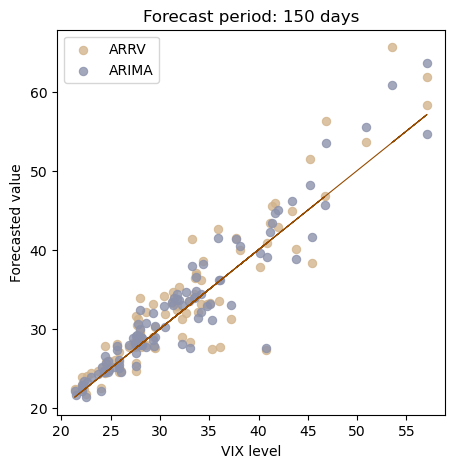

In [234]:
# 创建一个新的图形对象和一个子图对象
fig, ax = plt.subplots()

# 绘制一条曲线
x1=np.arange(2576,2676)
y1=f150 #ARIMA预测的VIX值
ax.scatter(Re,y2,color='#d2b48c', linewidth=0.8, label='ARRV',alpha=0.8)
ax.scatter(Re,y1,color='#8C92AC', linewidth=0.8, label='ARIMA',alpha=0.8)

#x2=np.arange(2576,2676)
#y2=Re
#ax.scatter(x2,y2,color='#d2b48c', linewidth=0.8, label='VIX')


ax.plot(Re,Re,color='#964B00',linewidth=0.8)

# 设置颜色的 RGB 值
color_rgb = '#5f9ea0'





# 显示图形
fig.set_size_inches(5, 5)

plt.legend()
ax.set_title('Forecast period: 150 days' )
plt.xlabel('VIX level')
plt.ylabel('Forecasted value')
plt.savefig('FIG/win150.png', dpi=800)
plt.show()

# 3. Window size: 200 days

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

df = prepare_data('./data/VIXdata.txt')
n = 200
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2019-06-12']['Date'].values[0:100] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)

In [242]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    params_ar,df_ori, forecast = obtain_residual_by_ar(df_ori)
 
    forecast = forecast.values
 
    df_ori = df_ori.dropna()
    df_ori,value_first = obtain_train(df_ori)
    df_ = df_ori.dropna()
   

    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    #print("lambda_ =", lambda_)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_) #+1/lambda_
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    #print("series is ", series)
    # Evaluate Hurst equation
    H=0.231183
    v,u_hat = obtain_v(df_,H)
    print("v = ", v)
    u_tmp = np.sign(df_['u'].values[-1])* np.power(np.abs(df_['u'].values[-1]),lambda_)

    z = compute_z(v,lambda_)
    # res = obtain_params(df_)
    # x = res.x
    #print("z = ",z)
    v_i = df_['log_vix'].values[-1] #volatility past value
    ar_i = df_['ar_predict'].values[-1] #ar approximte last value
    result = forecast +0.54*(z)+0*(v_i-(ar_i)) # predict_self(df_,v,x,lambda_)   ########


    df_true = df[df['Date'] >= date][0:n+1].reset_index(drop=True)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
   # print("value_first is in main:",value_first)from statsmodels.tsa.ar_model import AutoReg
    # print("2*df_['residual_mean'].values[-1] is in main:",2*df_['residual_mean'].values[-1])
    # log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    # return [forecast, result+2*df_['residual_mean'].values[-1]+value_first, date_,true_value,H,lambda_],df_,value_first
    return [forecast[0], result[0], date_,true_value,H,lambda_,value_first,z[0],u_tmp,u_hat[0]],df_,value_first

In [244]:
df_result = pd.DataFrame(result,columns=['ar','zhu','date','true','H','lambda_','value_first','z','u_tmp','u_hat'])
df_result

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat
0,4.113572,4.116638,2020-03-27,4.182661,0.231183,1.467948,0,0.005679,0.094752,0.230352
1,4.188648,4.174401,2020-03-30,4.044454,0.231183,1.459184,0,-0.026384,0.383888,0.436042
2,4.044086,4.059840,2020-03-31,3.980429,0.231183,1.447773,0,0.029174,0.019477,0.152895
3,3.978023,3.975917,2020-04-01,4.044103,0.231183,1.440929,0,-0.003898,0.166636,0.267057
4,4.043660,4.021842,2020-04-02,3.930059,0.231183,1.433366,0,-0.040404,0.517702,0.525120
...,...,...,...,...,...,...,...,...,...,...
95,3.182294,3.164557,2020-08-12,3.103689,0.231183,1.426573,0,-0.032847,0.570284,0.583347
96,3.107650,3.115592,2020-08-13,3.096934,0.231183,1.415531,0,0.014708,0.341408,0.518792
97,3.101014,3.095388,2020-08-14,3.093313,0.231183,1.416300,0,-0.010418,0.701359,0.738588
98,3.097912,3.093591,2020-08-17,3.061052,0.231183,1.430180,0,-0.008002,0.450211,0.538163


In [245]:
reg_model = LinearRegression()

reg_model.fit(df_result[['z']].values,df_result['true']-df_result['ar'])
reg_model.coef_

array([0.54075306])

In [246]:
# HMSE, HMAE    Mine
hmARRV = [hmse(df_result['true'].values,df_result['zhu'].values),hmae(df_result['true'].values,df_result['zhu'].values)]

mARRV = [mse(df_result['true'].values,df_result['zhu'].values),mae(df_result['true'].values,df_result['zhu'].values)]
# HMSE, HMAE      ARIMA
hmARIMA = hmse(df_result['true'].values,np.log(f200)),hmae(df_result['true'].values,np.log(f200))
mARIMA = mse(df_result['true'].values,np.log(f200)),mae(df_result['true'].values,np.log(f200))

print("ARRV的hmse和hmae:",hmARRV)
print("ARRV的mse和mae:",mARRV)
print("ARIMA的hmse和hmae:",hmARIMA)
print("ARIMA的mse和mae:",mARIMA)

ARRV的hmse和hmae: [0.0004215418297741063, 0.015307839160284206]
ARRV的mse和mae: [0.005383575659372986, 0.053646623130794345]
ARIMA的hmse和hmae: (0.009456544062231162, 0.07662951821314613)
ARIMA的mse和mae: (0.11446802092600228, 0.2654084595002556)


In [9]:
import arch

In [10]:
df_1

,Date,VIX,Log VIX,Log diff
0,2010-01-04,20.04,2.997730,-0.078660
1,2010-01-05,19.35,2.962692,-0.035038
2,2010-01-06,19.16,2.952825,-0.009868
3,2010-01-07,19.06,2.947592,-0.005233
4,2010-01-08,18.13,2.897568,-0.050024
...,...,...,...,...
3163,2022-07-25,23.36,3.151025,0.014227
3164,2022-07-26,24.69,3.206398,0.055373
3165,2022-07-27,23.24,3.145875,-0.060523
3166,2022-07-28,22.33,3.105931,-0.039944


In [36]:
fGarch=[]

for i in range(0, 100):
   # 取出需要预测的部分数据
    start_index = 2475+i
    end_index = 2575+i
    
    subset = df_1.loc[start_index:end_index, 'VIX']
    model = sm.tsa.ARIMA(subset, order=(1,0,0), seasonal_order=(1,0,0,1))
    results = model.fit()
    forecast = results.forecast(horizon=1)
    fGarch.append(forecast)

ValueError: Seasonal periodicity must be greater than 1.

TypeError: float() argument must be a string or a number, not 'ARCHModelForecast'

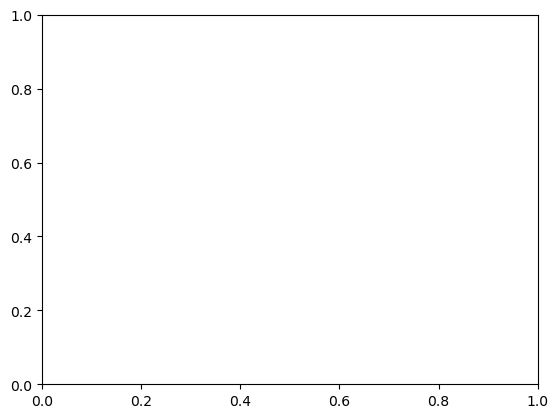

In [35]:
plt.plot(fGarch)
plt.show


In [14]:
Re = df_1.loc[2475:2575,'VIX']

In [16]:
print(df_1.loc[2475:2575])

           Date    VIX   Log VIX  Log diff
2475 2019-11-01  12.30  2.509599 -0.072132
2476 2019-11-04  12.83  2.551786  0.042187
2477 2019-11-05  13.10  2.572612  0.020826
2478 2019-11-06  12.62  2.535283 -0.037329
2479 2019-11-07  12.73  2.543961  0.008679
...         ...    ...       ...       ...
2571 2020-03-23  61.59  4.120500 -0.069761
2572 2020-03-24  61.67  4.121798  0.001298
2573 2020-03-25  63.95  4.158102  0.036304
2574 2020-03-26  61.00  4.110874 -0.047228
2575 2020-03-27  65.54  4.182661  0.071787

[101 rows x 4 columns]
